
### Autor: Victor M. Fonte Chavez

In [2]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 3.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import pickle
import numpy as np
import nltk
from tqdm.auto import tqdm
import copy
import os, shutil
import xml.etree.ElementTree as ET
import re
import emoji

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
import torch.nn.functional as F

from sklearn.metrics import f1_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Direcciones de directorios necesarios

In [2]:
#root_dir = "/content/drive/MyDrive/Local CIMAT/CIMAT/MAESTRIAS/1_Maestría CIMAT/Transformers y Diffusers/Tarea 1/_data"
root_dir = "/content/drive/MyDrive/tarea 1 Transformers/_data"
train_dir = os.path.join(root_dir, "train")
train_truth_dir = os.path.join(train_dir, "truth.txt")
val_dir = os.path.join(root_dir, "val")
val_truth_dir = os.path.join(val_dir, "truth.txt")
test_dir = os.path.join(root_dir, "test")
test_truth_dir = os.path.join(test_dir, "truth.txt")

#word2vec_col_dir = "/content/drive/MyDrive/Local CIMAT/CIMAT/MAESTRIAS/1_Maestría CIMAT/Transformers y Diffusers/Tarea 1/word2vec_col.txt"
word2vec_col_dir = "/content/drive/MyDrive/tarea 1 Transformers/word2vec_col.txt"


Antes de este codigo me di cuenta que casi todos los documentos tenian 100 tweets, asi que mi camino fue encontrar todos los archivos que tuvieran menos de 100 tweets y solo habia uno, por lo que agregue una linea para borrarlo dentro de la funcion

In [ ]:
def min_tweets_per_doc(root_dir):
    '''Calcula el mínimo de tweets por documento.'''
    min = 100
    xml_paths = []
    for i in os.listdir(root_dir):
      xml_path = os.path.join(root_dir, i)
      if i != 'truth.txt':
          tree = ET.parse(xml_path)
          root = tree.getroot()
          tweets = [doc.text for doc in root.findall(".//document")]
          if len(tweets) < min:
              min = len(tweets)
              xml_paths.append(xml_path)
              os.remove(xml_path)

    return min, xml_paths

min_train, train_xml_paths = min_tweets_per_doc(train_dir)
min_val, val_xml_paths = min_tweets_per_doc(val_dir)
min_test, test_xml_paths = min_tweets_per_doc(test_dir)
print(min_train, min_val, min_test)
print(len(train_xml_paths), len(val_xml_paths), len(test_xml_paths))


100 100 100
0 0 0


Se crea un conjunto de datos val para obtener metricas de validacion en el entrenamiento.

In [ ]:
def move_data(n_moves, from_dir, to_dir):
    '''Copia de una carpeta a otra, teniendo en cuenta el archivo de labels truth.txt.'''

    files = os.listdir(from_dir)
    # Tomar una muestra aleatoria de files
    files = np.random.choice(files, n_moves, replace=False)
    #mover archivos a carpeta de validación
    for file in files:
        shutil.move(os.path.join(from_dir, file), os.path.join(to_dir, file))

    label_train_dir = os.path.join(from_dir, 'truth.txt')
    label_val_dir = os.path.join(to_dir, 'truth.txt')

    with open(label_train_dir, 'r') as f:
        labels_train = f.readlines()

    with open(label_val_dir, 'w') as g:
        for i in range(len(labels_train)):
            labels_train[i] = labels_train[i].replace('\n','').split(':::')
            if labels_train[i][0] + ".xml" in files:
                g.write(labels_train[i][0]+':::'+labels_train[i][1]+":::"+labels_train[i][2]+'\n')

    with open(label_train_dir, 'w') as f:
        for i in range(len(labels_train)):
            if labels_train[i][0] + ".xml" not in files:
                f.write(labels_train[i][0]+':::'+labels_train[i][1]+":::"+labels_train[i][2]+'\n')

# move_data(500, '_data/train', '_data/val')

Se crea la clase en la que se cargan los datos. Esta devuelve author_embeddings, gender, country, que no es mas que el embeding de todo el documento inicial, el genero del autor y su respectivo pais

In [ ]:
# Contrar numero total de paises en el dataset
def count_countries():
    '''Cuenta el número de países en el dataset.'''
    with open(train_truth_dir, 'r') as f:
        labels = f.readlines()
    countries = []
    for label in labels:
        label = label.replace('\n','').split(':::')
        countries.append(label[2])
    with open(val_truth_dir, 'r') as f:
        labels = f.readlines()
    for label in labels:
        label = label.replace('\n','').split(':::')
        countries.append(label[2])
    with open(test_truth_dir, 'r') as f:
        labels = f.readlines()
    for label in labels:
        label = label.replace('\n','').split(':::')
        countries.append(label[2])
    countries = list(set(countries))
    return len(countries), countries

count_countries()

(7, ['argentina', 'chile', 'spain', 'colombia', 'mexico', 'venezuela', 'peru'])

En la funcion `preprocessed_text` se realiza la limpieza de datos. A continuacion se enumeran las transformaciones.
- Eliminar URLs
- Eliminar emojis
- Eliminar caracteres no alfabéticos
- Convertir a minúsculas

In [3]:
from typing import Iterable, Optional, Sequence, Union


from torch.utils.data import Dataset, Sampler
from torch.utils.data.dataloader import _collate_fn_t, _worker_init_fn_t


class CustomDataset(Dataset):
    def __init__(self, xml_dir, truth_file, embeddings_file):
        self.xml_dir = xml_dir
        self.truth_file = truth_file
        self.embeddings_file = embeddings_file
        self.country_index = ['colombia', 'argentina', 'spain', 'chile', 'peru', 'mexico', 'venezuela']
        self.data = self._load_data()
        self.vocab, self.emb_mat = self._load_vocab_embeddings()
        self.max_vec_len = self.max_sentence_len()

    def countrie_encoder(self, country):
        '''Codifica el país en un número.'''
        return self.country_index.index(country.lower())

    def _load_data(self):
        data = []
        with open(self.truth_file, 'r') as file:
            truth_lines = file.readlines()
        for line in truth_lines:
            author_code, gender, country = line.strip().split(":::")
            country = self.countrie_encoder(country)
            xml_path = os.path.join(self.xml_dir, f"{author_code}.xml")
            if os.path.exists(xml_path):
                data.append([xml_path, gender, country])

        #convertir a dataframe
        data = pd.DataFrame(data, columns=["path", "gender", "country"])

        return data

    def _load_vocab_embeddings(self):
        '''Embeddings preentrenados en twitter.
           emb_mat: Matriz de embeddings. Un vector de tamaño 100 para cada palabra del vocabulario.
           vocab: Diccionario, asigna a cada palabra su renglón correspondiente en la matriz de embeddings.
        '''
        embeddings_list = []
        self.vocab_dict = {}
        vocab = {}
        with open(self.embeddings_file, 'r') as f:
            for i, line in enumerate(f):
                if i!=0:
                    values = line.split()
                    self.vocab_dict[i+1] = values[0]
                    vocab[values[0]] = i+1
                    vector = np.asarray(values[1:], "float32")
                    embeddings_list.append(vector)
        embeddings_list.insert(0,np.mean(np.vstack(embeddings_list), axis=0))
        embeddings_list.insert(0,np.zeros(100))
        self.vocab_dict[0] = '[PAD]'
        self.vocab_dict[1] = '[UNK]'
        vocab['[PAD]'] = 0
        vocab['[UNK]'] = 1
        emb_mat = np.vstack(embeddings_list)

        return vocab, emb_mat

    def remove_emojis(self, text):
        # Eliminar emojis utilizando una expresión regular personalizada
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticones
                                   u"\U0001F300-\U0001F5FF"  # símbolos y pictogramas
                                   u"\U0001F680-\U0001F6FF"  # transportes
                                   u"\U0001F700-\U0001F77F"  # símbolos alquímicos
                                   u"\U0001F780-\U0001F7FF"  # símbolos extra
                                   u"\U0001F800-\U0001F8FF"  # símbolos chinos
                                   u"\U0001F900-\U0001F9FF"  # símbolos chinos extra
                                   u"\U0001FA00-\U0001FA6F"  # emojis para actividades
                                   u"\U0001FA70-\U0001FAFF"  # emojis de comida
                                   u"\U00002702-\U000027B0"  # emojis misceláneos
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    def clean_word(self, word):
        cleaned_word = re.sub(r'http\S+', '', word)  # Eliminar URLs
        cleaned_word = re.sub(r'[^a-zA-Z\s]', '', cleaned_word)  # Eliminar caracteres no alfabéticos
        cleaned_word = cleaned_word.lower()  # Convertir a minúsculas
        return cleaned_word

    def preprocessed_text(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        tweets = [doc.text for doc in root.findall(".//document")]

        # Tokenize tweets
        tokenizer = nltk.TweetTokenizer()
        words = []
        word_ids = []
        for tweet in tweets:
            # Eliminar emojis
            tweet_cleaned = self.remove_emojis(tweet)

            # Tokenizar y limpiar más el texto con NLTK (puedes añadir más limpiezas según tus necesidades)
            words_temp = tokenizer.tokenize(tweet_cleaned)
            words_temp = [self.clean_word(word) for word in words_temp]

            words.append(words_temp)
            word_ids.append(torch.tensor([self.vocab[word] if word in self.vocab.keys() \
                                          else self.vocab['[UNK]'] for word in words_temp]))
        return words, word_ids

    def max_sentence_len(self):
        '''Devuelve el tamaño máximo de los vectores de palabras.'''
        max_len = 0
        for doc in os.listdir(self.xml_dir):
            if doc.endswith('.xml'):
                xml_path = os.path.join(self.xml_dir, doc)
                words, words_ids = self.preprocessed_text(xml_path)
                max_len = max(max_len, max([len(t) for t in words_ids]))
        return max_len

    def get_padding(self, words_ids):
        '''Función para hacer padding a los tweets.'''
        max_len = self.max_vec_len

        padded = []
        for t in words_ids:
            padded.append(torch.cat((t, torch.zeros(max_len-len(t), dtype=torch.long))))
        return torch.stack(padded)

    def get_embedding(self, token):
        if token in self.vocab:
            return self.emb_mat[self.vocab[token]]
        else:
            return self.emb_mat[self.vocab['[UNK]']]

    def get_weights(self):
        '''Devuelve pesos inversos para cada categoría. Mayor peso para la categoría con menos observaciones.'''

        cat_0 = len(self.data[self.data['country']==0])
        cat_1 = len(self.data[self.data['country']==1])
        cat_2 = len(self.data[self.data['country']==2])
        cat_3 = len(self.data[self.data['country']==3])
        cat_4 = len(self.data[self.data['country']==4])
        cat_5 = len(self.data[self.data['country']==5])
        cat_6 = len(self.data[self.data['country']==6])

        maxi = max(cat_0, cat_1, cat_2, cat_3, cat_4, cat_5, cat_6)
        return torch.tensor([maxi/cat_0, maxi/cat_1, maxi/cat_2, maxi/cat_3, maxi/cat_4, maxi/cat_5, maxi/cat_6])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        row = self.data.iloc[idx]
        xml_path = row["path"]
        country = row["country"]
        country = torch.tensor(country)

        words, words_ids = self.preprocessed_text(xml_path)
        words_ids = self.get_padding(words_ids)
        words_ids = words_ids.long()

        return words_ids, country

### GRU con atención

La atencion herarquica hace lo siguiente, primero a nivel de palabras y luego, con los vectores de atencion de cada tweet, se hace a nivel de tweets:

$$ s = \sum_t \alpha_t h_t,$$

donde

\begin{align*}
    u_{t} &= \tanh(Wh_{t}+b),\\
    \alpha_{t} &= \frac{\exp(u_t^Tu)}{\sum_i\exp(u_{i}^Tu)}.
\end{align*}

Aqui reutilicé el codigo de atencion de la clase de verano

In [4]:
class AttnModule(nn.Module):
    def __init__(self, input_size, attn_hidden_size=128):
        super(AttnModule, self).__init__()
        self.fc1 = nn.Linear(input_size, attn_hidden_size)
        self.fc2 = nn.Linear(attn_hidden_size, 1, bias=False)

    def forward(self, x):
        seq_len, batch_size, nhid = x.size()
        u = self.fc1(x.reshape(batch_size*seq_len, nhid))
        u = torch.tanh(u)
        scores = self.fc2(u)
        scores = scores.view(seq_len, batch_size, 1)
        scores = F.softmax(scores, dim=0)
        scores = scores.transpose(0, 1)
        x = x.transpose(0, 1).transpose(1, 2)
        x = torch.bmm(x, scores)
        return x.squeeze(2), scores


class AttnGRU(nn.Module):
    def __init__(self, input_size=100, hidden_size=128, num_layers=1,
                 bidirectional=True, emb_mat=None, dense_hidden_size=256,
                 attn_hidden_size=128):
        super(AttnGRU, self).__init__()

        directions = 2 if bidirectional else 1

        self.embeddings = nn.Embedding.from_pretrained(\
                            torch.FloatTensor(emb_mat), freeze=False)
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=bidirectional)
        self.attn1 = AttnModule(input_size=hidden_size*directions)

        input_size_2 = hidden_size*directions
        hidden_size_2 = int(hidden_size*directions + input_size*0.3)
        self.gru2 = nn.GRU(input_size=input_size_2, hidden_size=hidden_size_2,
                          num_layers=num_layers, bidirectional=bidirectional)
        self.attn2 = AttnModule(input_size=hidden_size_2*directions)

        self.classifier = nn.Sequential(
                            nn.Linear(hidden_size_2*directions, dense_hidden_size),
                            nn.BatchNorm1d(dense_hidden_size),
                            nn.ReLU(),
                            nn.Linear(dense_hidden_size, 7))

    def forward(self, doc):

        tweets = doc.size(1)
        gru_outputs = []
        w_att = []
        for i in range(tweets):
            emb = self.embeddings(doc[:, i, :]).transpose(0, 1)
            x, _ = self.gru1(emb)
            x, scores = self.attn1(x)
            gru_outputs.append(x)
            w_att.append(scores)
        gru_outputs = torch.stack(gru_outputs)
        w_att = torch.stack(w_att)

        x, _ = self.gru2(gru_outputs)
        x, tweet_att = self.attn2(x)

        x = self.classifier(x)

        return x, w_att, tweet_att

In [ ]:
torch.cuda.empty_cache()

### Entrenamiento

In [7]:
from IPython.core import history

class Trainer:
    def __init__(
            self,
            model,
            criterion,
            optimizer,
            train_dataloader,
            val_dataloader,
            test_dataloader,
            checkpoints_dir,
            scheduler = None,
            batch_size=32,
    ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.batch_size = batch_size
        self.scheduler = scheduler
        self.checkpoints_dir = checkpoints_dir
        #self.checkpoints_dir = "/content/drive/MyDrive/Local CIMAT/CIMAT/MAESTRIAS/1_Maestría CIMAT/Transformers y Diffusers/Tarea 1/_checkpoint"
        self.history = {
            "train_acc": [],
            "val_acc": [],
            "train_loss":[],
            "val_loss":[]
        }

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        total_samples = 0
        total_correct = 0
        with tqdm(total=len(self.train_dataloader)) as progress_bar:
            for input_seq, country in self.train_dataloader:
                input_seq, country = input_seq.to(self.device), country.to(self.device)
                self.optimizer.zero_grad()
                output,_,_ = self.model(input_seq)  # Adjust 'lengths' accordingly
                output = F.softmax(output, dim=1)
                loss = self.criterion(output, country)

                _, predicted = torch.max(output, 1)
                total_correct += (predicted == country).sum().item()
                total_samples += country.size(0)

                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                progress_bar.update(1)
            accuracy = total_correct / total_samples
            mean_loss = total_loss / len(self.train_dataloader)
            self.history["train_loss"].append(mean_loss)
            self.history["train_acc"].append(accuracy)
            return mean_loss, accuracy

    def validate(self):
        self.model.eval()
        total_correct = 0
        total_samples = 0
        total_loss = 0
        with torch.no_grad():
            for input_seq, country in self.val_dataloader:
                input_seq, country = input_seq.to(self.device), country.to(self.device)
                output,_,_ = self.model(input_seq)  # Adjust 'lengths' accordingly
                _, predicted = torch.max(output, 1)
                total_correct += (predicted == country).sum().item()
                total_samples += country.size(0)

                loss_val = self.criterion(output, country)
                total_loss += loss_val.item()

        accuracy = total_correct / total_samples
        mean_loss = total_loss / len(self.val_dataloader)
        self.history["val_acc"].append(accuracy)
        self.history["val_loss"].append(mean_loss)

        if self.scheduler is not None:
          self.scheduler.step(accuracy)
        return mean_loss, accuracy

    def testing(self):
        self.model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for input_seq, country in self.test_dataloader:
                input_seq, country = input_seq.to(self.device), country.to(self.device)
                output, _, _ = self.model(input_seq)  # Adjust 'lengths' accordingly
                _, predicted = torch.max(output, 1)
                total_correct += (predicted == country).sum().item()
                total_samples += country.size(0)

        accuracy = total_correct / total_samples
        return accuracy

    def train(self, num_epochs):
        checkpoint_acc = 0
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_epoch()
            valid_loss, valid_accuracy = self.validate()
            if valid_accuracy > checkpoint_acc:
              checkpoint_acc = valid_accuracy
              torch.save(self.model, os.path.join(self.checkpoints_dir, "medelo"+str(epoch)+".ckpt"))
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train: {train_acc:.4f} - Validation Loss: {valid_loss:.4f} - Validation Accuracy: {valid_accuracy:.4f}")


In [6]:
lr = 2e-4
epochs = 50
weight_decay=0.0001
beta1=0
beta2=0.999
batch_size=128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
train_dataset = CustomDataset(train_dir, train_truth_dir, word2vec_col_dir)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CustomDataset(val_dir, val_truth_dir, word2vec_col_dir)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = CustomDataset(test_dir, test_truth_dir, word2vec_col_dir)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("ok")

ok


In [13]:
model = AttnGRU(emb_mat=train_dataset.emb_mat, bidirectional=True)
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay, betas = (beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=5,
                factor=0.5,
                verbose=True,
            )
weight = train_dataset.get_weights().to(device)
criterion = nn.NLLLoss(weight = weight)

In [ ]:
checkpoints_dir = "/content/drive/MyDrive/tarea 1 Transformers/_checkpoints"

trainer = Trainer(
    model,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    test_dataloader,
    batch_size=batch_size,
    scheduler = scheduler,
    checkpoints_dir = checkpoints_dir
)

trainer.train(epochs)



  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [1/50] - Train Loss: -0.2299 - Train: 0.2677 - Validation Loss: -0.0369 - Validation Accuracy: 0.2320


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [2/50] - Train Loss: -0.3649 - Train: 0.4392 - Validation Loss: -0.5658 - Validation Accuracy: 0.4780


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [3/50] - Train Loss: -0.5476 - Train: 0.6244 - Validation Loss: -3.0906 - Validation Accuracy: 0.6140


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [4/50] - Train Loss: -0.7089 - Train: 0.7758 - Validation Loss: -3.9182 - Validation Accuracy: 0.7420


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [5/50] - Train Loss: -0.7767 - Train: 0.8202 - Validation Loss: -4.1669 - Validation Accuracy: 0.7840


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [6/50] - Train Loss: -0.8152 - Train: 0.8561 - Validation Loss: -4.3565 - Validation Accuracy: 0.7800


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [7/50] - Train Loss: -0.8457 - Train: 0.8816 - Validation Loss: -4.7115 - Validation Accuracy: 0.8440


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [8/50] - Train Loss: -0.8632 - Train: 0.8943 - Validation Loss: -5.0720 - Validation Accuracy: 0.8680


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [9/50] - Train Loss: -0.8805 - Train: 0.9056 - Validation Loss: -4.9200 - Validation Accuracy: 0.8560


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [10/50] - Train Loss: -0.8948 - Train: 0.9173 - Validation Loss: -5.0161 - Validation Accuracy: 0.8440


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [11/50] - Train Loss: -0.9030 - Train: 0.9224 - Validation Loss: -5.0148 - Validation Accuracy: 0.8300


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [12/50] - Train Loss: -0.9129 - Train: 0.9308 - Validation Loss: -5.1941 - Validation Accuracy: 0.8500


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [13/50] - Train Loss: -0.9203 - Train: 0.9367 - Validation Loss: -5.5894 - Validation Accuracy: 0.8540


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [14/50] - Train Loss: -0.9264 - Train: 0.9392 - Validation Loss: -5.4456 - Validation Accuracy: 0.8800


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [15/50] - Train Loss: -0.9345 - Train: 0.9470 - Validation Loss: -5.5503 - Validation Accuracy: 0.8560


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [16/50] - Train Loss: -0.9405 - Train: 0.9513 - Validation Loss: -5.7642 - Validation Accuracy: 0.8760


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [17/50] - Train Loss: -0.9462 - Train: 0.9559 - Validation Loss: -5.7047 - Validation Accuracy: 0.8780


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [18/50] - Train Loss: -0.9495 - Train: 0.9581 - Validation Loss: -5.9040 - Validation Accuracy: 0.8820


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [19/50] - Train Loss: -0.9535 - Train: 0.9600 - Validation Loss: -5.9686 - Validation Accuracy: 0.8820


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [20/50] - Train Loss: -0.9556 - Train: 0.9621 - Validation Loss: -5.9637 - Validation Accuracy: 0.8740


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [21/50] - Train Loss: -0.9564 - Train: 0.9635 - Validation Loss: -5.9546 - Validation Accuracy: 0.8780


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [22/50] - Train Loss: -0.9591 - Train: 0.9667 - Validation Loss: -6.1978 - Validation Accuracy: 0.8440


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [23/50] - Train Loss: -0.9614 - Train: 0.9689 - Validation Loss: -5.8516 - Validation Accuracy: 0.8780


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.
Epoch [24/50] - Train Loss: -0.9645 - Train: 0.9697 - Validation Loss: -6.0391 - Validation Accuracy: 0.8780


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [25/50] - Train Loss: -0.9690 - Train: 0.9724 - Validation Loss: -6.0303 - Validation Accuracy: 0.8740


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [26/50] - Train Loss: -0.9698 - Train: 0.9735 - Validation Loss: -6.1203 - Validation Accuracy: 0.8840


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [27/50] - Train Loss: -0.9714 - Train: 0.9759 - Validation Loss: -6.0676 - Validation Accuracy: 0.8700


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [28/50] - Train Loss: -0.9723 - Train: 0.9765 - Validation Loss: -6.0795 - Validation Accuracy: 0.8680


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [29/50] - Train Loss: -0.9733 - Train: 0.9770 - Validation Loss: -6.0730 - Validation Accuracy: 0.8740


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [30/50] - Train Loss: -0.9751 - Train: 0.9781 - Validation Loss: -6.1203 - Validation Accuracy: 0.8840


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [31/50] - Train Loss: -0.9760 - Train: 0.9794 - Validation Loss: -6.0738 - Validation Accuracy: 0.8660


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [32/50] - Train Loss: -0.9767 - Train: 0.9800 - Validation Loss: -6.2406 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [33/50] - Train Loss: -0.9772 - Train: 0.9800 - Validation Loss: -6.2248 - Validation Accuracy: 0.8740


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [34/50] - Train Loss: -0.9776 - Train: 0.9803 - Validation Loss: -6.2070 - Validation Accuracy: 0.8840


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [35/50] - Train Loss: -0.9780 - Train: 0.9805 - Validation Loss: -6.2869 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [36/50] - Train Loss: -0.9775 - Train: 0.9805 - Validation Loss: -6.1795 - Validation Accuracy: 0.8620


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [37/50] - Train Loss: -0.9786 - Train: 0.9808 - Validation Loss: -6.2468 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 00038: reducing learning rate of group 0 to 5.0000e-05.
Epoch [38/50] - Train Loss: -0.9789 - Train: 0.9813 - Validation Loss: -6.3389 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [39/50] - Train Loss: -0.9795 - Train: 0.9816 - Validation Loss: -6.3028 - Validation Accuracy: 0.8800


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [40/50] - Train Loss: -0.9800 - Train: 0.9819 - Validation Loss: -6.3228 - Validation Accuracy: 0.8840


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [41/50] - Train Loss: -0.9802 - Train: 0.9824 - Validation Loss: -6.3268 - Validation Accuracy: 0.8780


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [42/50] - Train Loss: -0.9807 - Train: 0.9827 - Validation Loss: -6.3053 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [43/50] - Train Loss: -0.9805 - Train: 0.9827 - Validation Loss: -6.2974 - Validation Accuracy: 0.8880


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [44/50] - Train Loss: -0.9811 - Train: 0.9830 - Validation Loss: -6.3728 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [45/50] - Train Loss: -0.9812 - Train: 0.9832 - Validation Loss: -6.3637 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [46/50] - Train Loss: -0.9813 - Train: 0.9835 - Validation Loss: -6.3293 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [47/50] - Train Loss: -0.9816 - Train: 0.9835 - Validation Loss: -6.3264 - Validation Accuracy: 0.8820


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [48/50] - Train Loss: -0.9816 - Train: 0.9835 - Validation Loss: -6.3481 - Validation Accuracy: 0.8860


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 00049: reducing learning rate of group 0 to 2.5000e-05.
Epoch [49/50] - Train Loss: -0.9817 - Train: 0.9835 - Validation Loss: -6.4263 - Validation Accuracy: 0.8820


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch [50/50] - Train Loss: -0.9818 - Train: 0.9835 - Validation Loss: -6.3641 - Validation Accuracy: 0.8780


In [ ]:
pt = "medelo42.ckpt"
model = torch.load(os.path.join(checkpoints_dir, pt))

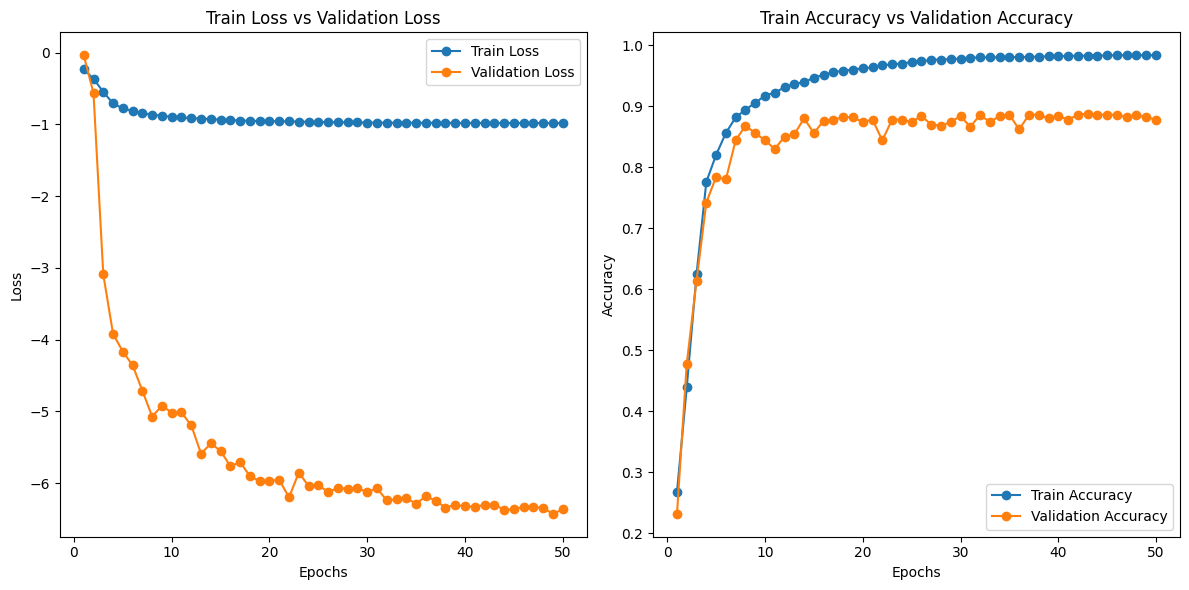

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    # Gráfico de Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss vs Validation Loss')
    plt.legend()

    # Gráfico de Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

train_loss = trainer.history["train_loss"]
val_loss = trainer.history["val_loss"]
train_acc = trainer.history["train_acc"]
val_acc = trainer.history["val_acc"]
plot_metrics(train_loss, val_loss, train_acc, val_acc)

El modelo fue entrenado durante 50 épocas midiendo en cada epoca el accuray y el loss tanto del entrenamiento como de la validacion. En general, el modelo parecía estar aprendiendo y generalizando bien, ya que tanto la pérdida como la precisión tanto en entrenamiento como en validación se mantuvieron en un rango aceptable.


La funcion implementada la tomé del codigo de la clase de verano y la modifique para que acepte colorear tanto las oraciones, como las palabras por importancia.

In [ ]:
from IPython.display import display, HTML
import matplotlib.colors as mcolors

def colorize_sentences(sentences, word_attention, sentence_attention):
    '''
        Función para visualizar la atención a nivel de palabras y oraciones.
    '''
    word_cmap = matplotlib.cm.get_cmap('Reds')

    sentence_cmap = matplotlib.cm.get_cmap('Blues')
    new_cmap = mcolors.ListedColormap(sentence_cmap(np.linspace(0.4, 0.7, 256)))
    sentence_cmap = new_cmap

    sentence_template = '<span class="sentence"; style="background-color: {}">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</span>'
    colored_strings = []

    for sentence, sentence_color in zip(sentences, sentence_attention):
        word_attention_for_sentence = word_attention[len(colored_strings)]
        word_colors = [word_cmap(attention)[:3] for attention in word_attention_for_sentence]
        sentence_color_hex = matplotlib.colors.rgb2hex(sentence_cmap(sentence_color)[:3])

        word_spans = []
        for word, word_color in zip(sentence, word_colors):
            word_color_hex = matplotlib.colors.rgb2hex(word_color)
            word_spans.append('<span class="word"; style="background-color: {}">{}</span>'.format(word_color_hex, word))
        word_span_string = ' '.join(word_spans)

        sentence_bar = sentence_template.format(sentence_color_hex)
        colored_strings.append(f'{word_span_string} {sentence_bar}')

    return colored_strings

In [ ]:
#xml_path = "/content/drive/MyDrive/Local CIMAT/CIMAT/MAESTRIAS/1_Maestría CIMAT/Transformers y Diffusers/Tarea 1/_data/test"
xml_path = "/content/drive/MyDrive/tarea 1 Transformers/_data/test"
xml_path = os.path.join(xml_path, os.listdir(xml_path)[0])

words, words_ids = test_dataset.preprocessed_text(xml_path)
words_ids = test_dataset.get_padding(words_ids)
words_ids = words_ids.long()
words_ids = words_ids.unsqueeze(0)
words_ids = words_ids.cuda()

_, w_scores, t_scores = model(words_ids)
w_scores = w_scores.squeeze(1).squeeze(2)
t_scores = t_scores.squeeze(0).squeeze(1)

w_scores = w_scores.cpu()
w_scores = w_scores.detach().numpy()
t_scores = t_scores.cpu()
t_scores = t_scores.detach().numpy()


In [ ]:
w_scores_fix = []
for i, tweet in enumerate(words):
  w_scores_fix.append(w_scores[i][:len(tweet)])

colored_strings = colorize_sentences(words, w_scores_fix, t_scores)
html_code = '<br>'.join(colored_strings)
display(HTML(f'<p style="font-size: 18px;">{html_code}</p>'))


<ipython-input-27-7aa2aecfcd3b>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  word_cmap = matplotlib.cm.get_cmap('Reds')
<ipython-input-27-7aa2aecfcd3b>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sentence_cmap = matplotlib.cm.get_cmap('Blues')


Como se puede apreciar la atencion sobre palabras funciona como se esperaba pues se pone intensidad en palagras como gentilicios, paises o palabras tipicas de el habla de ciertas regiones como por ejemplo vos.

Con respecto a las importancia sobre tweets no se ve mucha diferencia, pues los valores no son muy distantes entre si, pero se puede observar que las oraciones con palabras muy importantes, el color azul es ligeramente mayor, por lo que se puede concluir que tambien funciona.

Ahora se entrenara otro modelo para comparar si la atencion herarquica a dos niveles es mucho mejor que a un solo nivel

In [8]:
class AttnModule(nn.Module):
    def __init__(self, input_size, attn_hidden_size=128):
        super(AttnModule, self).__init__()
        self.fc1 = nn.Linear(input_size, attn_hidden_size)
        self.fc2 = nn.Linear(attn_hidden_size, 1, bias=False)

    def forward(self, x):
        seq_len, batch_size, nhid = x.size()
        u = self.fc1(x.reshape(batch_size*seq_len, nhid))
        u = torch.tanh(u)
        scores = self.fc2(u)
        scores = scores.view(seq_len, batch_size, 1)
        scores = F.softmax(scores, dim=0)
        scores = scores.transpose(0, 1)
        x = x.transpose(0, 1).transpose(1, 2)
        x = torch.bmm(x, scores)
        return x.squeeze(2), scores

class OneLevelAttnGRU(nn.Module):
    def __init__(self, input_size=100, hidden_size=128, num_layers=1,
                 bidirectional=True, emb_mat=None, dense_hidden_size=256,
                 attn_hidden_size=128):
        super(OneLevelAttnGRU, self).__init__()

        directions = 2 if bidirectional else 1

        self.embeddings = nn.Embedding.from_pretrained(\
                            torch.FloatTensor(emb_mat), freeze=False)
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=bidirectional)
        self.attn = AttnModule(input_size=hidden_size*directions)

        self.classifier = nn.Sequential(
                            nn.Linear(hidden_size*directions, dense_hidden_size),
                            nn.BatchNorm1d(dense_hidden_size),
                            nn.ReLU(),
                            nn.Linear(dense_hidden_size, 7))

    def forward(self, doc):

        batch_size, tweets, words = doc.size()

        emb = self.embeddings(doc).view(batch_size, tweets*words, 100).transpose(0, 1)
        gru_outputs, _ = self.gru(emb)
        x, tweet_att = self.attn(gru_outputs)

        x = self.classifier(x)
        h = None
        return x, tweet_att, h

In [9]:
lr = 2e-4
epochs = 50
weight_decay=0.0001
beta1=0
beta2=0.999
batch_size=64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
train_dataset = CustomDataset(train_dir, train_truth_dir, word2vec_col_dir)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CustomDataset(val_dir, val_truth_dir, word2vec_col_dir)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = CustomDataset(test_dir, test_truth_dir, word2vec_col_dir)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("ok")

ok


In [14]:
model = OneLevelAttnGRU(emb_mat=train_dataset.emb_mat, bidirectional=True)

optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay, betas = (beta1, beta2))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, "max",
                patience=5,
                factor=0.5,
                verbose=True,
            )
weight = train_dataset.get_weights().to(device)
criterion = nn.NLLLoss(weight = weight)

In [15]:
checkpoints_dir = "/content/drive/MyDrive/tarea 1 Transformers/_checkpoints_ej7"

trainer = Trainer(
    model,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    test_dataloader,
    batch_size=batch_size,
    scheduler = scheduler,
    checkpoints_dir = checkpoints_dir
)

trainer.train(epochs)

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [1/50] - Train Loss: -0.2298 - Train: 0.2885 - Validation Loss: -0.3949 - Validation Accuracy: 0.3200


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [2/50] - Train Loss: -0.4074 - Train: 0.4838 - Validation Loss: -2.7011 - Validation Accuracy: 0.5580


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [3/50] - Train Loss: -0.6180 - Train: 0.6842 - Validation Loss: -3.6347 - Validation Accuracy: 0.7160


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [4/50] - Train Loss: -0.7395 - Train: 0.7877 - Validation Loss: -3.9403 - Validation Accuracy: 0.7800


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [5/50] - Train Loss: -0.7825 - Train: 0.8221 - Validation Loss: -4.1541 - Validation Accuracy: 0.8120


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [6/50] - Train Loss: -0.8150 - Train: 0.8467 - Validation Loss: -4.7712 - Validation Accuracy: 0.8260


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [7/50] - Train Loss: -0.8326 - Train: 0.8629 - Validation Loss: -5.0219 - Validation Accuracy: 0.8420


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [8/50] - Train Loss: -0.8484 - Train: 0.8732 - Validation Loss: -4.9640 - Validation Accuracy: 0.8400


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [9/50] - Train Loss: -0.8642 - Train: 0.8886 - Validation Loss: -5.0995 - Validation Accuracy: 0.8500


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [10/50] - Train Loss: -0.8754 - Train: 0.9010 - Validation Loss: -5.4135 - Validation Accuracy: 0.8520


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [11/50] - Train Loss: -0.8876 - Train: 0.9105 - Validation Loss: -5.4562 - Validation Accuracy: 0.8540


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [12/50] - Train Loss: -0.8961 - Train: 0.9162 - Validation Loss: -5.5928 - Validation Accuracy: 0.8700


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [13/50] - Train Loss: -0.9065 - Train: 0.9229 - Validation Loss: -5.5757 - Validation Accuracy: 0.8600


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [14/50] - Train Loss: -0.9125 - Train: 0.9283 - Validation Loss: -5.8126 - Validation Accuracy: 0.8540


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [15/50] - Train Loss: -0.9190 - Train: 0.9346 - Validation Loss: -5.7505 - Validation Accuracy: 0.8680


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [16/50] - Train Loss: -0.9264 - Train: 0.9405 - Validation Loss: -5.9022 - Validation Accuracy: 0.8620


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [17/50] - Train Loss: -0.9312 - Train: 0.9419 - Validation Loss: -5.9230 - Validation Accuracy: 0.8580


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 1.0000e-04.
Epoch [18/50] - Train Loss: -0.9346 - Train: 0.9435 - Validation Loss: -6.0367 - Validation Accuracy: 0.8540


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [19/50] - Train Loss: -0.9413 - Train: 0.9481 - Validation Loss: -6.1926 - Validation Accuracy: 0.8760


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [20/50] - Train Loss: -0.9418 - Train: 0.9494 - Validation Loss: -6.1738 - Validation Accuracy: 0.8560


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [21/50] - Train Loss: -0.9439 - Train: 0.9508 - Validation Loss: -6.2598 - Validation Accuracy: 0.8680


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [22/50] - Train Loss: -0.9451 - Train: 0.9513 - Validation Loss: -6.2186 - Validation Accuracy: 0.8720


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [23/50] - Train Loss: -0.9468 - Train: 0.9535 - Validation Loss: -6.2957 - Validation Accuracy: 0.8720


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [24/50] - Train Loss: -0.9483 - Train: 0.9546 - Validation Loss: -6.2494 - Validation Accuracy: 0.8740


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 5.0000e-05.
Epoch [25/50] - Train Loss: -0.9502 - Train: 0.9565 - Validation Loss: -6.2150 - Validation Accuracy: 0.8640


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [26/50] - Train Loss: -0.9519 - Train: 0.9575 - Validation Loss: -6.2389 - Validation Accuracy: 0.8760


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [27/50] - Train Loss: -0.9540 - Train: 0.9611 - Validation Loss: -6.3269 - Validation Accuracy: 0.8680


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [28/50] - Train Loss: -0.9543 - Train: 0.9616 - Validation Loss: -6.3754 - Validation Accuracy: 0.8720


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [29/50] - Train Loss: -0.9549 - Train: 0.9619 - Validation Loss: -6.4222 - Validation Accuracy: 0.8740


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [30/50] - Train Loss: -0.9561 - Train: 0.9632 - Validation Loss: -6.3249 - Validation Accuracy: 0.8640


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00031: reducing learning rate of group 0 to 2.5000e-05.
Epoch [31/50] - Train Loss: -0.9566 - Train: 0.9627 - Validation Loss: -6.3484 - Validation Accuracy: 0.8580


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [32/50] - Train Loss: -0.9579 - Train: 0.9635 - Validation Loss: -6.4187 - Validation Accuracy: 0.8680


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [33/50] - Train Loss: -0.9589 - Train: 0.9646 - Validation Loss: -6.3833 - Validation Accuracy: 0.8600


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [34/50] - Train Loss: -0.9589 - Train: 0.9648 - Validation Loss: -6.3441 - Validation Accuracy: 0.8640


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [35/50] - Train Loss: -0.9589 - Train: 0.9646 - Validation Loss: -6.4859 - Validation Accuracy: 0.8640


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [36/50] - Train Loss: -0.9598 - Train: 0.9657 - Validation Loss: -6.3868 - Validation Accuracy: 0.8640


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 1.2500e-05.
Epoch [37/50] - Train Loss: -0.9596 - Train: 0.9654 - Validation Loss: -6.3964 - Validation Accuracy: 0.8660


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [38/50] - Train Loss: -0.9610 - Train: 0.9673 - Validation Loss: -6.3724 - Validation Accuracy: 0.8620


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [39/50] - Train Loss: -0.9605 - Train: 0.9662 - Validation Loss: -6.4013 - Validation Accuracy: 0.8680


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [40/50] - Train Loss: -0.9613 - Train: 0.9670 - Validation Loss: -6.4120 - Validation Accuracy: 0.8620


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [41/50] - Train Loss: -0.9609 - Train: 0.9667 - Validation Loss: -6.4273 - Validation Accuracy: 0.8680


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [42/50] - Train Loss: -0.9616 - Train: 0.9670 - Validation Loss: -6.4172 - Validation Accuracy: 0.8620


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00043: reducing learning rate of group 0 to 6.2500e-06.
Epoch [43/50] - Train Loss: -0.9613 - Train: 0.9673 - Validation Loss: -6.4376 - Validation Accuracy: 0.8600


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [44/50] - Train Loss: -0.9617 - Train: 0.9673 - Validation Loss: -6.4706 - Validation Accuracy: 0.8660


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [45/50] - Train Loss: -0.9613 - Train: 0.9667 - Validation Loss: -6.4450 - Validation Accuracy: 0.8620


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [46/50] - Train Loss: -0.9627 - Train: 0.9676 - Validation Loss: -6.4474 - Validation Accuracy: 0.8660


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [47/50] - Train Loss: -0.9624 - Train: 0.9676 - Validation Loss: -6.4384 - Validation Accuracy: 0.8620


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [48/50] - Train Loss: -0.9622 - Train: 0.9673 - Validation Loss: -6.4243 - Validation Accuracy: 0.8640


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00049: reducing learning rate of group 0 to 3.1250e-06.
Epoch [49/50] - Train Loss: -0.9628 - Train: 0.9676 - Validation Loss: -6.5051 - Validation Accuracy: 0.8620


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch [50/50] - Train Loss: -0.9628 - Train: 0.9676 - Validation Loss: -6.3775 - Validation Accuracy: 0.8620


Al no hacer atencion a dos niveles se pierde un poco de presicion, pero no tanta, solo dos decimas.